In [1]:
from tf_agents.environments import utils
from qnetwork.qpod_env import QPodEnvironment
from pod.board import PodBoard

environment = QPodEnvironment(PodBoard())
utils.validate_py_environment(environment, episodes=5)

print("valid!")

AttributeError: 'QPodEnvironment' object has no attribute '_get_pod'

In [2]:
import tensorflow as tf

from tf_agents.environments import wrappers

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tensorflow.python.keras.engine.input_layer import InputLayer



num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}



environment.reset()

env = wrappers.ActionDiscretizeWrapper(environment, num_actions=100)

train_env = tf_py_environment.TFPyEnvironment(QPodEnvironment(PodWorld()))
eval_env = tf_py_environment.TFPyEnvironment(QPodEnvironment(PodWorld()))

fc_layer_params = (100,)
preprocessing_combiner = InputLayer(
    input_shape=(6,)
)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    preprocessing_combiner=preprocessing_combiner)



optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [16]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
time_step = train_env.reset()

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("OK")

OK


In [17]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 2.6881228612262953e+18
step = 400: loss = 3.9356166594730394e+18
step = 600: loss = 4.78967825926665e+18
step = 800: loss = 6.893680070678807e+18
step = 1000: loss = 7.454886198658466e+18
step = 1000: Average Return = -96385744896.0
step = 1200: loss = 7.680946888840839e+18
step = 1400: loss = 9.044319866806338e+18
step = 1600: loss = 1.0457745362847269e+19
step = 1800: loss = 1.4396994258982666e+19
step = 2000: loss = 1.76328635765972e+19
step = 2000: Average Return = -96385744896.0
step = 2200: loss = 2.4202771008000623e+19
step = 2400: loss = 3.4125650143423234e+19
step = 2600: loss = 4.336984473148483e+19
step = 2800: loss = 5.270775509362829e+19
step = 3000: loss = 7.46462226417126e+19
step = 3000: Average Return = -96385744896.0
step = 3200: loss = 7.979405691812263e+19
step = 3400: loss = 9.100931301594943e+19
step = 3600: loss = 1.1979684959968297e+20
step = 3800: loss = 1.0467878462008852e+20
step = 4000: loss = 1.263436672869031e+20
step = 4000: Average Ret

(-101686960865.28, 250.0)

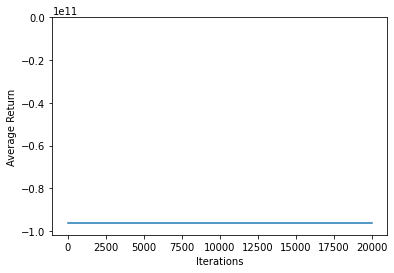

In [19]:
import matplotlib.pyplot as plt

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)
